In [1]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from utrees import Baltobot
from treeffuser import Treeffuser
time.time()

# Generate the data
seed = 0
n = 5000
rng = np.random.default_rng(seed=seed)
x = rng.uniform(0, 2 * np.pi, size=n)
z = rng.integers(0, 2, size=n)
y = z * np.sin(x - np.pi / 2) + (1 - z) * np.cos(x) + rng.laplace(scale=x / 30, size=n)

In [2]:
# Fit the models
start_time = time.time()
tfer = Treeffuser(sde_initialize_from_data=True, seed=seed)
tfer.fit(x, y)
tf_train_time = time.time() - start_time
y_tfer = tfer.sample(x, n_samples=1, seed=seed, verbose=True)
tf_time = time.time() - start_time

start_time = time.time()
tber = Baltobot(random_state=seed)
tber.fit(x.reshape(-1, 1), y)
tb_train_time = time.time() - start_time
y_tber = tber.sample(x.reshape(-1, 1))
tb_time = time.time() - start_time

start_time = time.time()
tbtaber = Baltobot(tabpfn=True, random_state=seed)
tbtaber.fit(x.reshape(-1, 1), y)
tbtab_train_time = time.time() - start_time
y_tbtaber = tbtaber.sample(x.reshape(-1, 1))
tbtab_time = time.time() - start_time

/Users/calvinm/miniconda3/envs/maskingtrees/lib/python3.9/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Users/calvinm/miniconda3/envs/maskingtrees/lib/python3.9/site-packages/treeffuser/_base_tabular_diffusion.py:113: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  y = _check_array(y)
/Users/calvinm/miniconda3/envs/maskingtrees/lib/python3.9/site-packages/treeffuser/_base_tabular_diffusion.py:110: CastFloat32Warning: Input array is not float32; it has been recast to float32.
  X = _check_array(X)
/Users/calvinm/sandbox/unmasking-trees/utrees/baltobot.py:95: UserWarning: Support for TabPFN is experimental.
  warnings.warn('Support for TabPFN is experimental.')
/Users/calvinm/miniconda3/envs/maskingtrees/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.re

In [8]:
fig, axes = plt.subplots(nrows=3, figsize=(5, 5), sharex=True, dpi=300);
axes[0].scatter(x, y, s=1, label="Observed data")
axes[0].scatter(x, y_tfer[0, :], s=1, alpha=0.7, label="Treeffuser samples")
axes[0].legend(loc='lower left');

axes[1].scatter(x, y, s=1, label="Observed data")
axes[1].scatter(x, y_tber, s=1, alpha=0.7, label="Baltobot samples")
ylims = axes[1].get_ylim();
axes[1].plot([2, 2], [-5, 5], '--', linewidth=0.2, color='black');
axes[1].set_ylim(ylims);
axes[1].legend(loc='lower left');

axes[2].scatter(x, y, s=1, label="Observed data")
axes[2].scatter(x, y_tbtaber, s=1, alpha=0.7, label="BaltoboTabPFN samples")
axes[2].legend(loc='lower left');
ylims = axes[2].get_ylim();
axes[2].plot([2, 2], [-5, 5], '--', linewidth=0.2, color='black');
axes[2].set_ylim(ylims);
plt.suptitle('(A)                                                                                    ');
plt.tight_layout();
plt.savefig('wave-demo.png');
plt.close();

plt.figure(dpi=200, figsize=(4,3));
total_time_df = pd.DataFrame.from_dict({'Treeffuser': [tf_time], 'Baltobot': [tb_time], 'BaltoboTabPFN': [tbtab_time]}).T
total_time_df.columns = ['Total']
train_time_df = pd.DataFrame.from_dict({'Treeffuser': [tf_train_time], 'Baltobot': [tb_train_time], 'BaltoboTabPFN': [tbtab_train_time]}).T
train_time_df.columns = ['Training']
time_df = pd.concat([total_time_df, train_time_df], axis=1)
time_df['Sampling'] = time_df['Total'] - time_df['Training']

time_dff = time_df.stack().reset_index()
time_dff.columns = ['Method', 'Task', 'Time']
sns.barplot(data=time_dff, y='Method', x='Time', hue='Task');
plt.ylabel('Method');
plt.xlabel('Time (s)');
plt.tight_layout();
plt.savefig('wave-demo-time.png');
plt.close()
time_dff

,Method,Task,Time
0,Treeffuser,Total,6.034639
1,Treeffuser,Training,1.062486
2,Treeffuser,Sampling,4.972153
3,Baltobot,Total,3.279673
4,Baltobot,Training,2.554989
5,Baltobot,Sampling,0.724684
6,BaltoboTabPFN,Total,20.779521
7,BaltoboTabPFN,Training,1.310628
8,BaltoboTabPFN,Sampling,19.468893


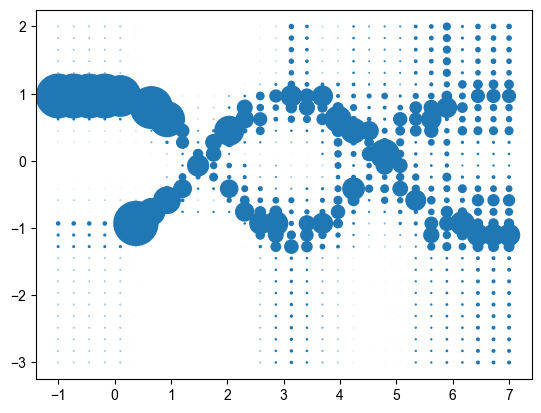

In [4]:
lhs, rhs = np.meshgrid(np.linspace(-1, 7, 30), np.linspace(-3,2, 30))
lhsrhs = np.hstack([lhs.reshape(-1, 1), rhs.reshape(-1, 1)])
plt.figure();
plt.scatter(lhsrhs[:, 0], lhsrhs[:, 1])
scores = tber.score_samples(lhs.reshape(-1, 1), rhs.reshape(-1))
plt.close();
plt.figure();
plt.scatter(lhsrhs[:, 0], lhsrhs[:, 1], s=100*np.exp(scores));
#plt.close();

0.9820769258371294 1.0016803929615847


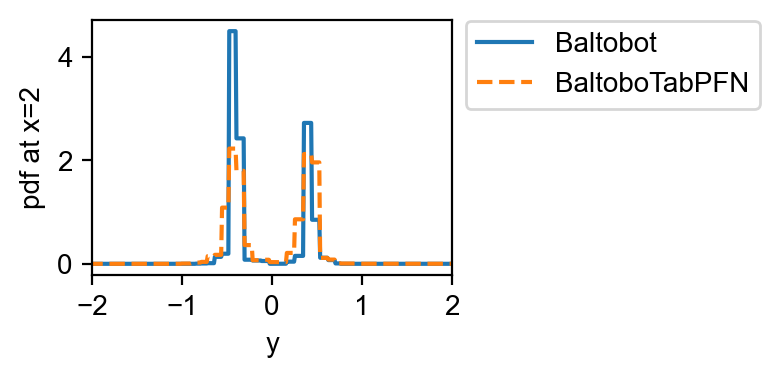

In [5]:
Xs = 2 * np.ones((1000, 1))
Ys = np.linspace(-5, 5, 1000)
tb_scores = tber.score_samples(Xs, Ys)
tbtab_scores = tbtaber.score_samples(Xs, Ys)
print(np.exp(tb_scores).sum() * (Ys[1]-Ys[0]), np.exp(tbtab_scores).sum() * (Ys[1]-Ys[0]))
plt.figure(figsize=(4,2), dpi=200);
plt.plot(Ys, np.exp(tb_scores), label='Baltobot');
plt.plot(Ys, np.exp(tbtab_scores), '--', label='BaltoboTabPFN');
plt.xlim(-2, 2);
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05));
plt.xlabel('y');
plt.ylabel('pdf at x=2');
plt.tight_layout();
plt.savefig('wave-pdfat2.png');
#plt.close();

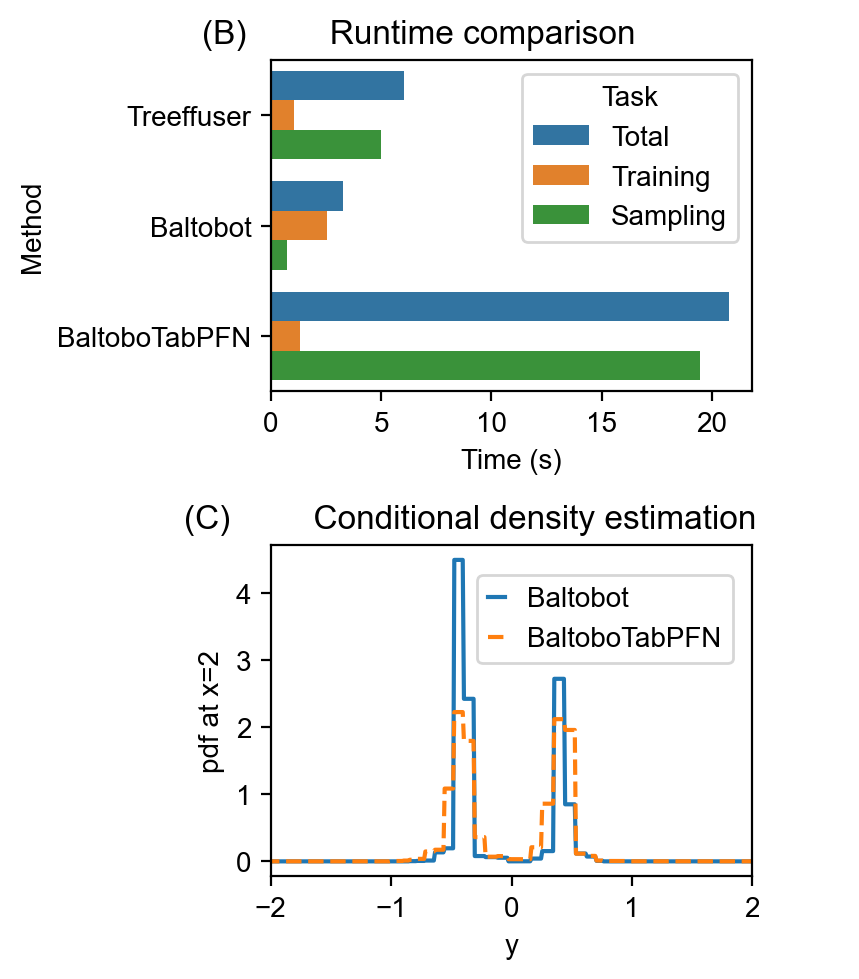

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 5), dpi=200);
sns.barplot(data=time_dff, y='Method', x='Time', hue='Task',ax=axes[0]);
axes[0].set_ylabel('Method');
axes[0].set_xlabel('Time (s)');
axes[0].set_title('(B)         Runtime comparison                    ');

axes[1].plot(Ys, np.exp(tb_scores), label='Baltobot');
axes[1].plot(Ys, np.exp(tbtab_scores), '--', label='BaltoboTabPFN');
axes[1].set_xlim(-2, 2);
axes[1].legend(loc='upper left', bbox_to_anchor=(0.4, 0.95), handlelength=0.6, );
axes[1].set_xlabel('y');
axes[1].set_ylabel('pdf at x=2');
axes[1].set_title('(C)         Conditional density estimation         ');
plt.tight_layout();
plt.savefig('wave-time-pdfat2.png');